## AlphaFold database analysis script

Basic script to download alphafold predicted structure

- Author : Bo Zhang
- Date : 2024-01-15

## data analysis

1. download  afdb / 3dbeacons

2. parse afdb / 3dbeacons

In [1]:
import os
import re
from typing import List, Tuple, Dict, Set, Optional, Sequence, Tuple
import pathlib
import json
import requests

import numpy as np
from IPython.display import clear_output


In [2]:
import dataclasses
import os
from typing import Any, Mapping, MutableMapping, Optional, Sequence, Union
import collections
import string


# zb : basic scripts from AlphaFold data pipeline files
# 1. parse_fasta into a tuple of sequences and descriptions
# 2. parse_sto msa file (HMMER format) into MSA objects
# 3. parse_a3m msa file (HHblits format) into MSA objects

DeletionMatrix = Sequence[Sequence[int]]

@dataclasses.dataclass(frozen=True)
class Msa:
  """Class representing a parsed MSA file."""
  sequences: Sequence[str]
  deletion_matrix: DeletionMatrix
  descriptions: Sequence[str]

  def __post_init__(self):
    # __post_init__在init之后紧接着被调用
    if not (len(self.sequences) ==
            len(self.deletion_matrix) ==
            len(self.descriptions)):
      raise ValueError(
          'All fields for an MSA must have the same length. '
          f'Got {len(self.sequences)} sequences, '
          f'{len(self.deletion_matrix)} rows in the deletion matrix and '
          f'{len(self.descriptions)} descriptions.')

  def __len__(self):
    return len(self.sequences)

  def truncate(self, max_seqs: int):
    return Msa(sequences=self.sequences[:max_seqs],
               deletion_matrix=self.deletion_matrix[:max_seqs],
               descriptions=self.descriptions[:max_seqs])



def parse_fasta(fasta_string: str) -> Tuple[Sequence[str], Sequence[str]]:
  """Parses FASTA string and returns list of strings with amino-acid sequences.

  Arguments:
    fasta_string: The string contents of a FASTA file.

  Returns:
    A tuple of two lists:
    * A list of sequences.
    * A list of sequence descriptions taken from the comment lines. In the
      same order as the sequences.
  """
  sequences = []
  descriptions = []
  index = -1
  for line in fasta_string.splitlines():
    line = line.strip()
    if line.startswith('>'):
      index += 1
      descriptions.append(line[1:])  # Remove the '>' at the beginning.
      sequences.append('')
      continue
    elif not line:
      continue  # Skip blank lines.
    sequences[index] += line

  return sequences, descriptions


def parse_stockholm(stockholm_string: str) -> Msa:
  """Parses sequences and deletion matrix from stockholm format alignment.

  Args:
    stockholm_string: The string contents of a stockholm file. The first
      sequence in the file should be the query sequence.

  Returns:
    A tuple of:
      * A list of sequences that have been aligned to the query. These
        might contain duplicates.
      * The deletion matrix for the alignment as a list of lists. The element
        at `deletion_matrix[i][j]` is the number of residues deleted from
        the aligned sequence i at residue position j.
      * The names of the targets matched, including the jackhmmer subsequence
        suffix.
  deletion_matrix 表示每一行msa 相对于native序列的删除
  """
  name_to_sequence = collections.OrderedDict()
  for line in stockholm_string.splitlines():
    line = line.strip()
    if not line or line.startswith(('#', '//')):
      continue
    name, sequence = line.split() # 默认str的split()函数以任意空格为分隔符
    if name not in name_to_sequence:
      name_to_sequence[name] = ''
    name_to_sequence[name] += sequence

  msa = []
  deletion_matrix = []

  query = ''
  keep_columns = []
  for seq_index, sequence in enumerate(name_to_sequence.values()):
      if seq_index == 0:
        # Gather the columns with gaps from the query --- 从第一条序列, 即native序列中找到非gap的位置
        query = sequence
        keep_columns = [i for i, res in enumerate(query) if res != '-']

      # Remove the columns with gaps in the query from all sequences.
      aligned_sequence = ''.join([sequence[c] for c in keep_columns])

      msa.append(aligned_sequence)

      # Count the number of deletions w.r.t. query.
      deletion_vec = []
      deletion_count = 0
      for seq_res, query_res in zip(sequence, query):
        # 考虑到如果query 和 seq 在此位置上都是gap，就不用统计，我们本心不关注于seq_res是否是gap
        if seq_res != '-' or query_res != '-':
          if query_res == '-':
            deletion_count += 1
          else:
            deletion_vec.append(deletion_count)
            deletion_count = 0
      deletion_matrix.append(deletion_vec)
  # return msa, deletion_matrix, name_to_sequence
  return Msa(sequences=msa,deletion_matrix=deletion_matrix,descriptions=list(name_to_sequence.keys()))

def parse_a3m(a3m_string: str) -> Msa:
  """Parses sequences and deletion matrix from a3m format alignment.

  Args:
    a3m_string: The string contents of a a3m file. The first sequence in the
      file should be the query sequence.

  Returns:
    A tuple of:
      * A list of sequences that have been aligned to the query. These
        might contain duplicates.
      * The deletion matrix for the alignment as a list of lists. The element
        at `deletion_matrix[i][j]` is the number of residues deleted from
        the aligned sequence i at residue position j.
      * A list of descriptions, one per sequence, from the a3m file.
  """
  sequences, descriptions = parse_fasta(a3m_string) # a3m本质上就是带有特殊字符的fasta文件
  deletion_matrix = []
  for msa_sequence in sequences:
    deletion_vec = []
    deletion_count = 0
    for j in msa_sequence:
      if j.islower():
        deletion_count += 1
      else:
        deletion_vec.append(deletion_count)
        deletion_count = 0
    deletion_matrix.append(deletion_vec)

  # Make the MSA matrix out of aligned (deletion-free) sequences.
  deletion_table = str.maketrans('', '', string.ascii_lowercase)
  aligned_sequences = [s.translate(deletion_table) for s in sequences]
  return Msa(sequences=aligned_sequences,
             deletion_matrix=deletion_matrix,
             descriptions=descriptions)


In [5]:
# https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v1.pdb
# https://www.ebi.ac.uk/pdbe/pdbe-kb/3dbeacons/api/uniprot/summary/{uniprot_id}.json

In [35]:
def download_3dbbeacons(uniprot_id):
    """
    download meta data file from a uniprot id
    """
    file_path = f"./{uniprot_id}.json"
    url = f"https://www.ebi.ac.uk/pdbe/pdbe-kb/3dbeacons/api/uniprot/summary/{uniprot_id}.json"

    if os.path.exists(file_path):
        return -1 # already downloaded

    response = requests.get(url)
    if response.status_code == 404:
        print(f"{uniprot_id} not found")
        return -1 # not found
    data = response.json()
    with open(file_path, "w") as f:
        json.dump(data, f)
    return 1

def download_afdb(uniprot_id):
    """
    download predicted data structure file from a uniprot id
    """
    file_path = f"./{uniprot_id}.pdb"
    url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v1.pdb"

    if os.path.exists(file_path):
        return -1 # already downloaded
    response = requests.get(url)
    if response.status_code == 404:
        print(f"{uniprot_id} not found")
        return -1 # not found
    data = response.text
    with open(file_path, "w") as f:
        f.write(data)
    return 1 # downloaded
download_3dbbeacons("S9VV54")
download_afdb("S9VV54")
download_3dbbeacons("G2TRP5")
download_afdb("G2TRP5")


S9VV54 not found
S9VV54 not found


In [3]:
def load_info_from_afdb(uniprot_id):
    prediction = requests.get(f"https://alphafold.ebi.ac.uk/api/prediction/{uniprot_id}")
    prediction = json.loads(prediction.text)[0]
    # prediction info : protein , gene, organism
    protein = prediction['uniprotDescription']
    gene = prediction['gene']
    source_organism = prediction['organismScientificName']
    summary = requests.get(f"https://alphafold.ebi.ac.uk/api/uniprot/summary/{uniprot_id}.json")
    summary = json.loads(summary.text)
    # summary info : ave_plddt , experimental_method, resolution, created_date, length, start ,end
    ave_plddt = summary['structures'][0]['summary']['confidence_avg_local_score']
    experimental_method = summary['structures'][0]['summary']['experimental_method']
    resolution = summary['structures'][0]['summary']['resolution']
    created_date = summary['structures'][0]['summary']['created']
    length = summary['uniprot_entry']['sequence_length']
    start = summary['structures'][0]['summary']['uniprot_start']
    end = summary['structures'][0]['summary']['uniprot_end']
    return {"uniprot":uniprot_id,"protein":protein, "gene":gene, "source_organism":source_organism, "ave_plddt":ave_plddt, "experimental_method":experimental_method, "resolution":resolution, "created_date":created_date, "length":length, "start":start, "end":end}


In [23]:

def parse_3dbeacon(data):
    if isinstance(data,str):
        with open(data) as f:
            data = json.load(f)
    structure = data['structures']
    result = {"AlphaFold":[],"PDB":[]}
    for item in structure:
        item = item['summary']
        temp = {}
        if item['provider'] == "AlphaFold DB":
            temp['model_identifier'] = item['model_identifier']
            temp['url'] = item['model_url'].replace(".cif",".pdb")
            temp['af_start'] = item['uniprot_start']
            temp['af_end'] = item['uniprot_end']
            temp['pLDDT'] = item['confidence_avg_local_score']
            temp['coverage'] = item['coverage']
            temp['date'] = item['created']
            result['AlphaFold'].append(temp)
        elif item['model_category'] == 'EXPERIMENTALLY DETERMINED':
            temp['model_identifier'] = item['model_identifier']
            temp['url'] = item['model_url']
            temp['pdb_start'] = item['uniprot_start']
            temp['pdb_end'] = item['uniprot_end']
            temp['coverage'] = item['coverage']
            temp['experimental_method'] = item['experimental_method']
            temp['date'] = item['created']
            try:
                temp['resolution'] = item['resolution']
            except KeyError:
                pass
            result['PDB'].append(temp)
    return result

In [12]:
download_3dbbeacons("G2TRP5")

In [28]:
# analysize the pdb file in these gene numbers
dataset = ['cryophilus','pombe','japonicus','octosporus']
pdb_entry = {key:[] for key in dataset}
for species in dataset:
    for protein in os.listdir(f"../../omics/fission_yeast_afdb/metadata/{species}"):
        file = f"../../omics/fission_yeast_afdb/metadata/{species}/{protein}"
        try:
            result = parse_3dbeacon(file)
            if len(result['PDB']) > 0:
                pdb_entry[species].extend([protein for _ in range(len(result['PDB']))])
        except:
            pass
for key in pdb_entry:
    print(key,len(pdb_entry[key]),len(set(pdb_entry[key])))

## plot

1. pLDDT distribution

2. UpSet plot  

3. Violin plot  

4. scatter plot (y=x axis)  

In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns 

# basic script to parse the afdb data
def get_msa(file):
    msa = parse_stockholm(file)
    return len(msa.sequences),len(msa.sequences[0])

def get_af2_feedback(folder,return_msa=False,return_template=False):
    with open(os.path.join(folder,"ranking_debug.json"),"r") as f:
        plddt = json.load(f)
    feature = np.load(os.path.join(folder,"features.pkl"),allow_pickle=True)
    msa_length = len(feature['msa'])
    template_length = len(feature['template_aatype'])
    if return_msa and return_template:
        return round(plddt['plddts'][plddt['order'][0]],2),msa_length,template_length
    if return_msa:
        return round(plddt['plddts'][plddt['order'][0]],2),msa_length
    if return_template:
        return round(plddt['plddts'][plddt['order'][0]],2),template_length
    return round(plddt['plddts'][plddt['order'][0]],2)

In [5]:
file_list = os.listdir("/xcfhome/bozhang/alphafold-demo/output/pombe_specific_msa")
af2_data = []
for file in file_list:
    name,native_plddt  = file.split("_")
    customize_msa_path=f"/xcfhome/bozhang/omics/pombe_specific/msa/{file}.sto"
    with open(customize_msa_path,"r") as f:
        customize_msa_str = f.read()
    customize_folder = f"/xcfhome/bozhang/alphafold-demo/output/pombe_specific_msa/{file}"
    single_chain_folder = f"/xcfhome/bozhang/alphafold-demo/output/pombe_specific_single_seq/{file}"
    vanilla = f"/xcfhome/bozhang/af231/output/pombe_specific_vanilla/{file}"
    sed_customize = f"/xcfhome/bozhang/alphafold-demo/output/pombe_specific_msa_only/{file}"
    sed_both_customize = f"/xcfhome/bozhang/alphafold-demo/output/pombe_specific_msa_only_0113/{file}"
    fungi_customize = f"/xcfhome/bozhang/alphafold-demo/output/pombe_specific_msa_fungi/{file}"
    fungi_sed_customize = f"/xcfhome/bozhang/alphafold-demo/output/pombe_specific_msa_fungi_sed/{file}"
    sed_only_plddt = get_af2_feedback(sed_customize)
    sed_both_plddt = get_af2_feedback(sed_both_customize)
    fungi_plddt = get_af2_feedback(fungi_customize)
    fungi_sed_plddt = get_af2_feedback(fungi_sed_customize)
    msa_depth,length = get_msa(customize_msa_str)
    vanilla_plddt = get_af2_feedback(vanilla)
    customize_plddt,total_msa_depth,template_depth = get_af2_feedback(customize_folder,return_msa=True,return_template=True)
    single_chain_plddt = get_af2_feedback(single_chain_folder)
    af2_data.append([name,float(native_plddt),vanilla_plddt,customize_plddt,sed_both_plddt,fungi_plddt,fungi_sed_plddt,sed_only_plddt,single_chain_plddt,total_msa_depth-msa_depth,msa_depth-1,template_depth,length])

af2_data = pd.DataFrame(af2_data,columns=["name","native_plddt","vanilla_plddt","customize_plddt","sed_both_plddt","fungi_plddt","fungi_sed_plddt","sed_only_plddt","single_chain_plddt","bfd_msa_depth","msa_depth","template_depth","length"])

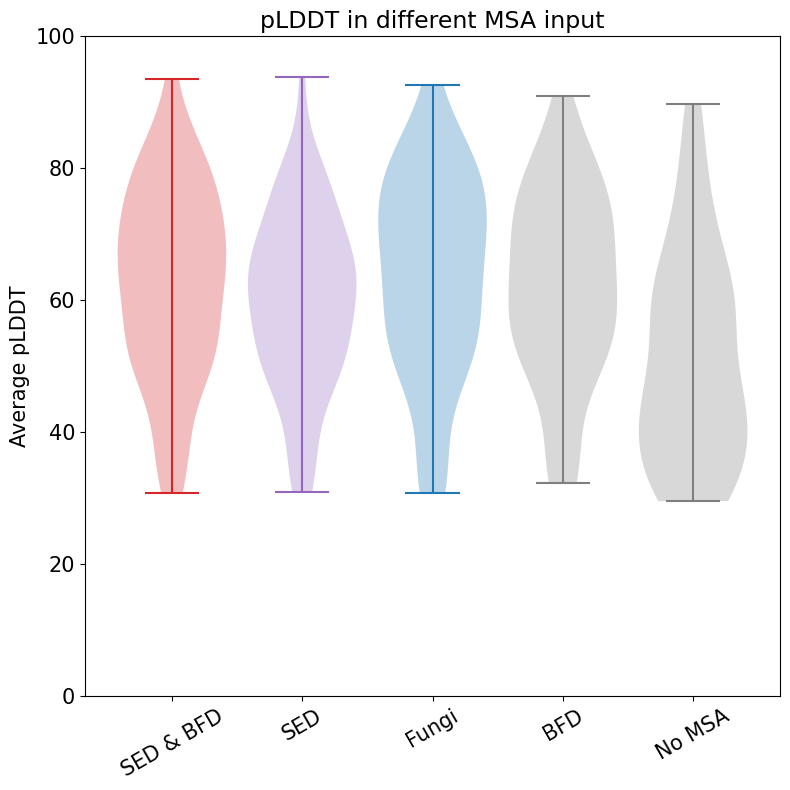

In [7]:
plddt_all = [np.array(af2_data['customize_plddt']),np.array(af2_data['sed_both_plddt']),np.array(af2_data['fungi_sed_plddt']),np.array(af2_data['vanilla_plddt']),np.array(af2_data['single_chain_plddt'])]

color_list_paper = ["tab:red","tab:purple","tab:blue","tab:gray","tab:gray"]

tick_list_paper = ['SED & BFD', 'SED', 'Fungi','BFD', 'No MSA']
plt.figure(figsize=(8,8))

for i in range(len(plddt_all)):
    
    parts = plt.violinplot(plddt_all[i],positions=[0+0.6*i])
    for pc in parts['bodies']:
        pc.set_facecolor(color_list_paper[i])
    parts['cbars'].set_color(color_list_paper[i])
    parts['cmaxes'].set_color(color_list_paper[i])
    parts['cmins'].set_color(color_list_paper[i])


plt.xlim(-0.4,0.4+0.6*(len(plddt_all)-1))
plt.ylim(0,100)

plt.title("pLDDT in different MSA input",fontsize=17)
plt.ylabel("Average pLDDT",fontsize=15)
plt.xticks(np.arange(0,0.6*(len(plddt_all)-1)+0.1,0.6),tick_list_paper,fontsize=15,rotation=30)
# plt.xticks(np.arange(0,0.6*(len(plddt_all)-1)+0.1,0.6),tick_list_paper,fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

plt.savefig("./plddt_msa_groups.pdf")

/tmp/ipykernel_1145692/3849202029.py:11: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(data=af2_data[af2_data['significant'] == 'Significant'], x="vanilla_plddt", y="customize_plddt", hue='color', palette=['#A6CED4', '#B598BC'], s=200, edgecolor='red',legend=False)


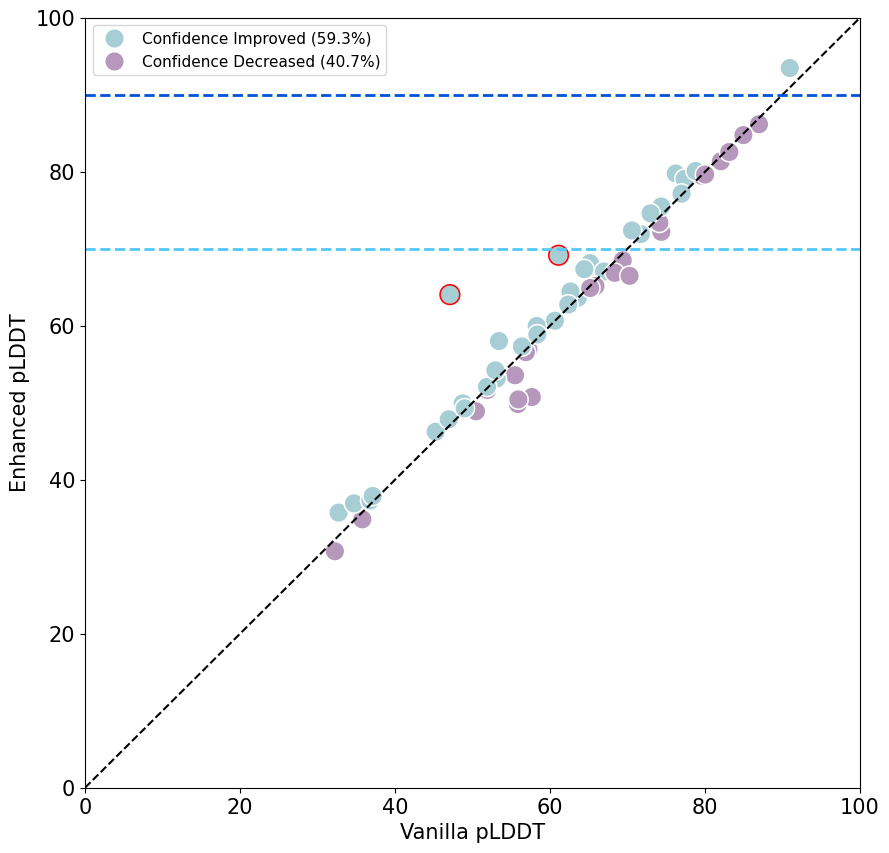

In [14]:
# scatter plot
# 创建一个新的列来表示哪些点是显著的
af2_data['significant'] = np.where(af2_data['customize_plddt'] - af2_data['vanilla_plddt'] > 5, 'Significant', 'Not Significant')

# 创建一个新的列来表示点的颜色
af2_data['groups'] = np.where(af2_data['customize_plddt'] > af2_data['vanilla_plddt'], 'Confidence Improved (59.3%)', 'Confidence Decreased (40.7%)')

# 画散点图
plt.figure(figsize=(10,10))
sns.scatterplot(data=af2_data[af2_data['significant'] == 'Not Significant'], x="vanilla_plddt", y="customize_plddt", hue='color', palette=['#A6CED4', '#B598BC'], s=200,legend=True)
sns.scatterplot(data=af2_data[af2_data['significant'] == 'Significant'], x="vanilla_plddt", y="customize_plddt", hue='color', palette=['#A6CED4', '#B598BC'], s=200, edgecolor='red',legend=False)

# 画y=x线
plt.plot([0,100],[0,100],color="black",linestyle="--")
plt.xlabel("Vanilla pLDDT",fontsize=15)
plt.ylabel("Enhanced pLDDT",fontsize=15)
plt.xlim(0,100)
plt.ylim(0,100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("./customize_vs_vanilla_red.pdf")
# plt.axhline(50, color='#FFDB14', linestyle='--', linewidth=2)
plt.axhline(70, color='#54C8F9', linestyle='--', linewidth=2)
plt.axhline(90, color='#0053D7', linestyle='--', linewidth=2)

# plt.axhline(13.5, color='k', linestyle='--', linewidth=2)

legend = plt.legend(prop={'size': 11})
plt.show()

In [ ]:
# UpSet plot : http://www.ehbio.com/test/venn/#/
# upset_structure = []
# for _,row in struc_cluster.iterrows():
#     cluster_id = row['CLUSTER_ID']
#     scy4=sj5=so6=sp2=0
#     if row['SCY4'] is not np.nan:
#         scy4 = 1
#     if row['SJ5'] is not np.nan:
#         sj5 = 1
#     if row['SO6'] is not np.nan:
#         so6 = 1
#     if row['SP2'] is not np.nan:
#         sp2 = 1
#     upset_structure.append([cluster_id,scy4,sj5,so6,sp2])
# upset_structure = pd.DataFrame(upset_structure, columns=['CLUSTER_ID','SCY4','SJ5','SO6','SP2'])
# upset_structure.to_csv("./upset_structure.csv", index=False)

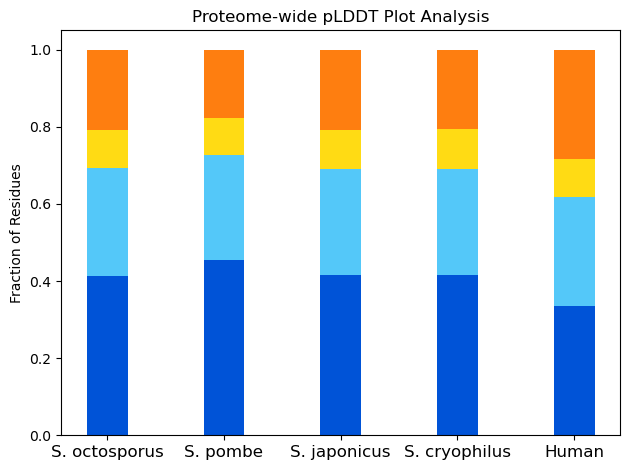

In [15]:
# pLDDT plot
japonicus = [0.41406868491465637,0.27869169588552867,0.1000930447718826,0.20714657442793236]
pombe = [0.45395424641742693,0.2716090606138904,0.09588465097379295,0.17855204199488978]
octosporus = [0.41612323718168115,0.27441426997404417,0.10195736024342396,0.20750513260085074]
cryophilus = [0.41443168874602326,0.2752743138329807,0.10383525270677547,0.20645874471422057]
human = [0.334,0.284,0.098,0.283]
length_aa = [1902310,2264085,1972197,1993793,14850403]

# Calculate the proportions
proportions = {
    "japonicus": {
        "<50": japonicus[3],
        "<70": japonicus[2],
        "<90": japonicus[1],
        ">=90": japonicus[0],
    },
    "pombe": {
        "<50": pombe[3],
        "<70": pombe[2],
        "<90": pombe[1],
        ">=90": pombe[0],
    },
    "octosporus": {
        "<50": octosporus[3],
        "<70": octosporus[2],
        "<90": octosporus[1],
        ">=90": octosporus[0],
    },
    "cryophilus": {
        "<50": cryophilus[3],
        "<70": cryophilus[2],
        "<90": cryophilus[1],
        ">=90": cryophilus[0],
    },
    "human": {
        "<50": human[3],
        "<70": human[2],
        "<90": human[1],
        ">=90": human[0],
    },
}

labels = list(proportions.keys())
labels_x = ['S. octosporus', 'S. pombe', 'S. japonicus', 'S. cryophilus', "Human"]
less_than_50 = [proportions[species]["<50"] for species in labels]
less_than_70 = [proportions[species]["<70"] for species in labels]
less_than_90 = [proportions[species]["<90"] for species in labels]
greater_than_90 = [proportions[species][">=90"] for species in labels]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
# rects1 = ax.bar(x, less_than_50, width, label='pLDDT<50')
# rects2 = ax.bar(x, less_than_70, width, bottom=less_than_50, label='pLDDT<70')
# rects3 = ax.bar(x, less_than_90, width, bottom=np.array(less_than_50)+np.array(less_than_70), label='pLDDT<90')
# rects4 = ax.bar(x, greater_than_90, width, bottom=np.array(less_than_50)+np.array(less_than_70)+np.array(less_than_90), label='pLDDT>90')

# give the color A7ACAD
rects1 = ax.bar(x, less_than_50, width, bottom=np.array(greater_than_90)+np.array(less_than_70)+np.array(less_than_90), label=r'pLDDT $\in$ [0,50)', color='#FE7E10')
rects2 = ax.bar(x, less_than_70, width, bottom=np.array(greater_than_90)+np.array(less_than_90), label=r'pLDDT $\in$ [50,70)', color='#FFDB14')
rects3 = ax.bar(x, less_than_90, width, bottom=greater_than_90, label=r'pLDDT $\in$ [70,90)', color='#54C8F9')
rects4 = ax.bar(x, greater_than_90, width, label=r'pLDDT $\in$ [90,100)', color='#0053D7')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fraction of Residues')
ax.set_title('Proteome-wide pLDDT Plot Analysis')
ax.set_xticks(x)
ax.set_xticklabels(labels_x,fontsize=12)

# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
# ax.legend()

fig.tight_layout()

plt.savefig('plddt_Schizosaccharomyces.pdf')


plt.show()

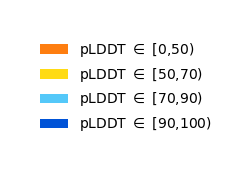

In [16]:
# Create a new figure for the legend
fig_legend = plt.figure(figsize=(3, 2))
axi = fig_legend.add_subplot(111)

# Add the legend to the new figure
handles, labels = ax.get_legend_handles_labels()
fig_legend.legend(handles, labels, loc='center', scatterpoints=1,frameon=False)

# Hide the axes of the new figure
axi.xaxis.set_visible(False)
axi.yaxis.set_visible(False)
axi.spines['top'].set_visible(False)
axi.spines['right'].set_visible(False)
axi.spines['bottom'].set_visible(False)
axi.spines['left'].set_visible(False)

# Show the new figure with the legend
plt.savefig('plddt_legend.png',dpi=500)

fig_legend.show()
